# Statistiques descriptives

In [1]:
import pandas as pd
import numpy as np
import os
import s3fs
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

In [2]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

# 1 - Comportement d'achat

## Outlier

In [3]:
# Chargement des données temporaires
BUCKET = "projet-bdc2324-team1"
FILE_KEY_S3 = "0_Temp/Company 1 - Purchasing behaviour.csv"
FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    tickets_kpi = pd.read_csv(file_in, sep=",")

In [4]:
tickets_kpi.head()

customer_id  event_type_id  nb_tickets  nb_purchases  total_amount  \
0            1              2      384226        194790     2686540.5   
1            1              4      453242        228945     3248965.5   
2            1              5      201750        107110     1459190.0   
3            1              6      217356        111786     1435871.5   
4            2              2         143           143           0.0   

   nb_suppliers  vente_internet_max  purchase_date_min  purchase_date_max  \
0             7                   1        3262.190868           4.179306   
1             6                   1        3698.198229           5.221840   
2             6                   1        3803.369792           0.146331   
3             5                   1        2502.715509        1408.715532   
4             1                   0        2041.274549        1340.308160   

   time_between_purchase  nb_tickets_internet          name_event_types  \
0            3258.011562                 51.0  offre muséale individuel   
1            3692.976389               2988.0          spectacle vivant   
2            3803.223461                  9.0      offre muséale groupe   
3            1093.999977                  5.0          formule adhésion   
4             700.966389                  0.0  offre muséale individuel   

   avg_amount  
0    6.150659  
1    7.762474  
2    4.452618  
3    6.439463  
4    6.150659

In [5]:
tickets_kpi.columns

Index(['customer_id', 'event_type_id', 'nb_tickets', 'nb_purchases',
       'total_amount', 'nb_suppliers', 'vente_internet_max',
       'purchase_date_min', 'purchase_date_max', 'time_between_purchase',
       'nb_tickets_internet', 'name_event_types', 'avg_amount'],
      dtype='object')

In [6]:
# Présence d'outlier
tickets_kpi.sort_values(by = ['nb_tickets'], axis = 0, ascending = False).head(10)

customer_id  event_type_id  nb_tickets  nb_purchases  total_amount  \
1                1              4      453242        228945     3248965.5   
0                1              2      384226        194790     2686540.5   
3                1              6      217356        111786     1435871.5   
2                1              5      201750        107110     1459190.0   
5032          6733              6       14208           114           0.0   
5029          6733              2       11656           158         471.0   
5030          6733              4        7440           162           0.0   
60              41              6        6583           634       12546.5   
57              41              2        6514           812       22423.0   
36376        63488              4        5750             9       63250.0   

       nb_suppliers  vente_internet_max  purchase_date_min  purchase_date_max  \
1                 6                   1        3698.198229           5.221840   
0                 7                   1        3262.190868           4.179306   
3                 5                   1        2502.715509        1408.715532   
2                 6                   1        3803.369792           0.146331   
5032              3                   1        2492.187199        1442.405116   
5029              3                   1        2982.237384         489.495324   
5030              2                   1        1036.392674         426.201944   
60                4                   1        2501.337905        1409.370521   
57                6                   1        3576.106609         247.232697   
36376             1                   1         887.298484         440.265162   

       time_between_purchase  nb_tickets_internet          name_event_types  \
1                3692.976389               2988.0          spectacle vivant   
0                3258.011562                 51.0  offre muséale individuel   
3                1093.999977                  5.0          formule adhésion   
2                3803.223461                  9.0      offre muséale groupe   
5032             1049.782083              13497.0          formule adhésion   
5029             2492.742060               9815.0  offre muséale individuel   
5030              610.190729               7419.0          spectacle vivant   
60               1091.967384               6391.0          formule adhésion   
57               3328.873912               5321.0  offre muséale individuel   
36376             447.033322               5750.0          spectacle vivant   

       avg_amount  
1        7.762474  
0        6.150659  
3        6.439463  
2        4.452618  
5032     6.439463  
5029     6.150659  
5030     7.762474  
60       6.439463  
57       6.150659  
36376    7.762474

In [7]:
# Part du CA par customer
total_amount_share = tickets_kpi.groupby('customer_id')['total_amount'].sum().reset_index()
total_amount_share['total_amount_entreprise'] = total_amount_share['total_amount'].sum()
total_amount_share['share_total_amount'] = total_amount_share['total_amount']/total_amount_share['total_amount_entreprise']

total_amount_share_index = total_amount_share.set_index('customer_id')
df_circulaire = total_amount_share_index['total_amount'].sort_values(axis = 0, ascending = False)


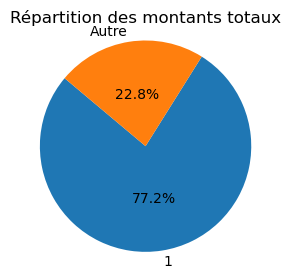

In [8]:
# Costumer 1 vs others customers
coupure = 1

top = df_circulaire[:coupure]
rest = df_circulaire[coupure:]

# Calculez la somme du reste
rest_sum = rest.sum()

# Créez une nouvelle série avec les cinq plus grandes parts et 'Autre'
new_series = pd.concat([top, pd.Series([rest_sum], index=['Autre'])])

# Créez le graphique circulaire
plt.figure(figsize=(3, 3))
plt.pie(new_series, labels=new_series.index, autopct='%1.1f%%', startangle=140, pctdistance=0.5)
plt.axis('equal')  # Assurez-vous que le graphique est un cercle
plt.title('Répartition des montants totaux')
plt.show()


In [9]:
tickets_kpi_filtered  = tickets_kpi[tickets_kpi['customer_id'] != 1]

## Evolution des commandes

In [3]:
# Importation - Chargement des données temporaires
def custom_date_parser(date_string):
    return pd.to_datetime(date_string, utc = True, format = 'ISO8601')

# Achat
BUCKET = "projet-bdc2324-team1"
FILE_KEY_S3 = "0_Input/Company_1/products_purchased_reduced.csv"
FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    purchases = pd.read_csv(file_in, sep=",", parse_dates = ['purchase_date'], date_parser=custom_date_parser)
    
# Emails
BUCKET = "projet-bdc2324-team1"
FILE_KEY_S3 = "0_Input/Company_1/campaigns_information.csv"
FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    campaigns = pd.read_csv(file_in, sep=",", parse_dates = ['sent_at'], date_parser=custom_date_parser)


/tmp/ipykernel_1235/3643128924.py:11: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  purchases = pd.read_csv(file_in, sep=",", parse_dates = ['purchase_date'], date_parser=custom_date_parser)
/tmp/ipykernel_1235/3643128924.py:19: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  campaigns = pd.read_csv(file_in, sep=",", parse_dates = ['sent_at'], date_parser=custom_date_parser)


In [4]:
# Mois du premier achat
purchase_min = purchases.groupby(['customer_id'])['purchase_date'].min().reset_index()
purchase_min.rename(columns = {'purchase_date' : 'first_purchase_event'}, inplace = True)
purchase_min['first_purchase_event'] = pd.to_datetime(purchase_min['first_purchase_event'])
purchase_min['first_purchase_month'] = pd.to_datetime(purchase_min['first_purchase_event'].dt.strftime('%Y-%m'))

# Mois du premier mails
first_mail_received = campaigns.groupby('customer_id')['sent_at'].min().reset_index()
first_mail_received.rename(columns = {'sent_at' : 'first_email_reception'}, inplace = True)
first_mail_received['first_email_reception'] = pd.to_datetime(first_mail_received['first_email_reception'])
first_mail_received['first_email_month'] = pd.to_datetime(first_mail_received['first_email_reception'].dt.strftime('%Y-%m'))

# Fusion 
known_customer = pd.merge(purchase_min[['customer_id', 'first_purchase_month']], 
                          first_mail_received[['customer_id', 'first_email_month']], on = 'customer_id', how = 'outer')

# Mois à partir duquel le client est considere comme connu
known_customer['known_date'] = pd.to_datetime(known_customer[['first_email_month', 'first_purchase_month']].min(axis = 1), utc = True, format = 'ISO8601')

In [5]:
# Nombre de commande par mois
purchases_count = pd.merge(purchases[['customer_id', 'purchase_id', 'purchase_date']].drop_duplicates(), known_customer[['customer_id', 'known_date']], on = ['customer_id'], how = 'inner')
purchases_count['is_customer_known'] = purchases_count['purchase_date'] > purchases_count['known_date'] + pd.DateOffset(months=1)
purchases_count['purchase_date_month'] = pd.to_datetime(purchases_count['purchase_date'].dt.strftime('%Y-%m'))
purchases_count = purchases_count[purchases_count['customer_id'] != 1]

# Nombre de commande par mois par type de client
nb_purchases_graph = purchases_count.groupby(['purchase_date_month', 'is_customer_known'])['purchase_id'].count().reset_index()
nb_purchases_graph.rename(columns = {'purchase_id' : 'nb_purchases'}, inplace = True)

nb_purchases_graph_2 = purchases_count.groupby(['purchase_date_month', 'is_customer_known'])['customer_id'].nunique().reset_index()
nb_purchases_graph_2.rename(columns = {'customer_id' : 'nb_new_customer'}, inplace = True)

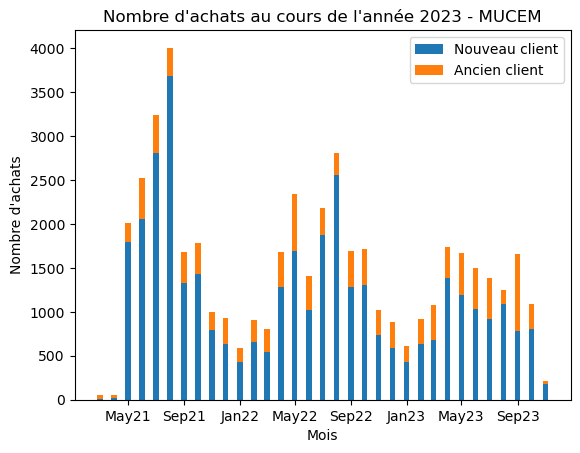

In [8]:
# Graphique en nombre de commande
purchases_graph = nb_purchases_graph

purchases_graph_used = purchases_graph[purchases_graph["purchase_date_month"] >= datetime(2021,3,1)]
purchases_graph_used_0 = purchases_graph_used[purchases_graph_used["is_customer_known"]==False]
purchases_graph_used_1 = purchases_graph_used[purchases_graph_used["is_customer_known"]==True]


# Création du barplot
plt.bar(purchases_graph_used_0["purchase_date_month"], purchases_graph_used_0["nb_purchases"], width=12, label = "Nouveau client")
plt.bar(purchases_graph_used_0["purchase_date_month"], purchases_graph_used_1["nb_purchases"], 
        bottom = purchases_graph_used_0["nb_purchases"], width=12, label = "Ancien client")


# commande pr afficher slt
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))


# Ajout de titres et d'étiquettes
plt.xlabel('Mois')
plt.ylabel("Nombre d'achats")
plt.title("Nombre d'achats - MUCEM")
plt.legend()

# Affichage du barplot
plt.show()

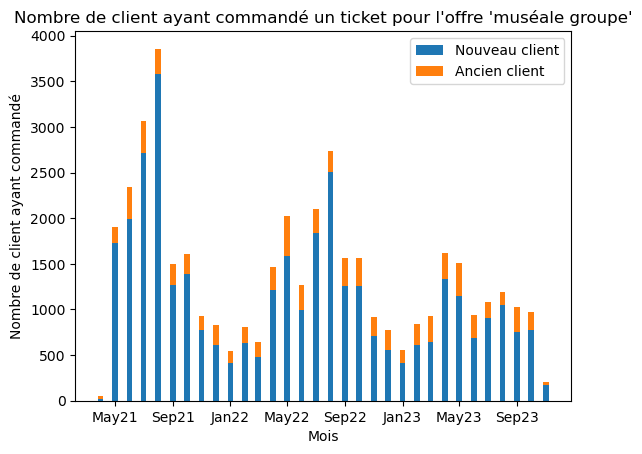

In [16]:
# graphique en nombre de client ayant commandé
purchases_graph = nb_purchases_graph_2

purchases_graph_used = purchases_graph[purchases_graph["purchase_date_month"] >= datetime(2021,4,1)]
purchases_graph_used_0 = purchases_graph_used[purchases_graph_used["is_customer_known"]==False]
purchases_graph_used_1 = purchases_graph_used[purchases_graph_used["is_customer_known"]==True]


# Création du barplot
plt.bar(purchases_graph_used_0["purchase_date_month"], purchases_graph_used_0["nb_new_customer"], width=12, label = "Nouveau client")
plt.bar(purchases_graph_used_0["purchase_date_month"], purchases_graph_used_1["nb_new_customer"], 
        bottom = purchases_graph_used_0["nb_new_customer"], width=12, label = "Ancien client")


# commande pr afficher slt
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))


# Ajout de titres et d'étiquettes
plt.xlabel('Mois')
plt.ylabel("Nombre de client ayant commandé")
plt.title("Nombre de client ayant commandé un ticket pour l'offre 'muséale groupe'")
plt.legend()

# Affichage du barplot
plt.show()

### Proportion de tickets de prix 0

In [17]:
purchases[purchases['amount'] == 0].count()/len(purchases)

ticket_id              0.418220
customer_id            0.418220
purchase_id            0.418220
event_type_id          0.418220
supplier_name          0.418220
purchase_date          0.418220
type_of_ticket_name    0.418220
amount                 0.418220
children               0.418220
is_full_price          0.418220
name_event_types       0.418220
name_facilities        0.418220
name_categories        0.402548
name_events            0.175585
name_seasons           0.418220
dtype: float64

In [18]:
purchases.groupby('customer_id')[['purchase_id', 'ticket_id']].nunique().describe()

purchase_id     ticket_id
count   73518.000000  7.351800e+04
mean       10.096167  2.484660e+01
std      2367.702603  4.636993e+03
min         1.000000  1.000000e+00
25%         1.000000  1.000000e+00
50%         1.000000  2.000000e+00
75%         1.000000  3.000000e+00
max    641981.000000  1.256574e+06

In [17]:
purchases

ticket_id  customer_id  purchase_id  event_type_id   supplier_name  \
0         13070859        48187      5107462              4  vente en ligne   
1         13070860        48187      5107462              4  vente en ligne   
2         13070861        48187      5107462              4  vente en ligne   
3         13070862        48187      5107462              4  vente en ligne   
4         13070863        48187      5107462              4  vente en ligne   
...            ...          ...          ...            ...             ...   
1826667   20662815      1256135      8007697              5  vente en ligne   
1826668   20662816      1256136      8007698              5  vente en ligne   
1826669   20662817      1256136      8007698              5  vente en ligne   
1826670   20662818      1256137      8007699              5  vente en ligne   
1826671   20662819      1256137      8007699              5  vente en ligne   

                    purchase_date type_of_ticket_name  amount  \
0       2018-12-28 14:47:50+00:00             Atelier     8.0   
1       2018-12-28 14:47:50+00:00             Atelier     4.0   
2       2018-12-28 14:47:50+00:00             Atelier     4.0   
3       2018-12-28 14:47:50+00:00             Atelier     4.0   
4       2018-12-28 14:47:50+00:00             Atelier     4.0   
...                           ...                 ...     ...   
1826667 2023-11-08 17:23:54+00:00             Atelier    11.0   
1826668 2023-11-08 18:32:18+00:00             Atelier    11.0   
1826669 2023-11-08 18:32:18+00:00             Atelier    11.0   
1826670 2023-11-08 19:30:28+00:00             Atelier    11.0   
1826671 2023-11-08 19:30:28+00:00             Atelier    11.0   

                children  is_full_price      name_event_types name_facilities  \
0        pricing_formula          False      spectacle vivant           mucem   
1        pricing_formula          False      spectacle vivant           mucem   
2        pricing_formula          False      spectacle vivant           mucem   
3        pricing_formula          False      spectacle vivant           mucem   
4        pricing_formula          False      spectacle vivant           mucem   
...                  ...            ...                   ...             ...   
1826667  pricing_formula          False  offre muséale groupe           mucem   
1826668  pricing_formula          False  offre muséale groupe           mucem   
1826669  pricing_formula          False  offre muséale groupe           mucem   
1826670  pricing_formula          False  offre muséale groupe           mucem   
1826671  pricing_formula          False  offre muséale groupe           mucem   

           name_categories            name_events  name_seasons  
0        indiv prog enfant  l'école des magiciens          2018  
1        indiv prog enfant  l'école des magiciens          2018  
2        indiv prog enfant  l'école des magiciens          2018  
3        indiv prog enfant  l'école des magiciens          2018  
4        indiv prog enfant  l'école des magiciens          2018  
...                    ...                    ...           ...  
1826667   indiv entrées tp                    NaN          2023  
1826668   indiv entrées tp                    NaN          2023  
1826669   indiv entrées tp                    NaN          2023  
1826670   indiv entrées tp                    NaN          2023  
1826671   indiv entrées tp                    NaN          2023  

[1826672 rows x 15 columns]

# 2 - Comportement d'achat bis (Alexis)

In [18]:
# Chargement des données temporaires
BUCKET = "projet-bdc2324-team1"
FILE_KEY_S3 = "0_Temp/Company 1 - customer_event.csv"
FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    customer = pd.read_csv(file_in, sep=",")

print(customer.shape)
customer.head()

(156289, 40)


customer_id birthdate  street_id  is_partner  gender  is_email_true  \
0            1       NaN          2       False       2           True   
1            1       NaN          2       False       2           True   
2            1       NaN          2       False       2           True   
3            1       NaN          2       False       2           True   
4            2       NaN          2       False       1           True   

   opt_in  structure_id profession language  ...  vente_internet_max  \
0   False           NaN        NaN      NaN  ...                 1.0   
1   False           NaN        NaN      NaN  ...                 1.0   
2   False           NaN        NaN      NaN  ...                 1.0   
3   False           NaN        NaN      NaN  ...                 1.0   
4    True           NaN        NaN      NaN  ...                 0.0   

  purchase_date_min  purchase_date_max  time_between_purchase  \
0       3262.190868           4.179306            3258.011562   
1       2502.715509        1408.715532            1093.999977   
2       3698.198229           5.221840            3692.976389   
3       3803.369792           0.146331            3803.223461   
4       1705.261192        1456.333715             248.927477   

   nb_tickets_internet          name_event_types  avg_amount  nb_campaigns  \
0                 51.0  offre muséale individuel    6.150659           NaN   
1                  5.0          formule adhésion    6.439463           NaN   
2               2988.0          spectacle vivant    7.762474           NaN   
3                  9.0      offre muséale groupe    4.452618           NaN   
4                  0.0          formule adhésion    6.439463           4.0   

   nb_campaigns_opened  time_to_open  
0                  NaN           NaN  
1                  NaN           NaN  
2                  NaN           NaN  
3                  NaN           NaN  
4                  NaN           NaN  

[5 rows x 40 columns]

In [19]:
customer.columns

Index(['customer_id', 'birthdate', 'street_id', 'is_partner', 'gender',
       'is_email_true', 'opt_in', 'structure_id', 'profession', 'language',
       'mcp_contact_id', 'last_buying_date', 'max_price', 'ticket_sum',
       'average_price', 'fidelity', 'average_purchase_delay',
       'average_price_basket', 'average_ticket_basket', 'total_price',
       'purchase_count', 'first_buying_date', 'country', 'age', 'tenant_id',
       'event_type_id', 'nb_tickets', 'nb_purchases', 'total_amount',
       'nb_suppliers', 'vente_internet_max', 'purchase_date_min',
       'purchase_date_max', 'time_between_purchase', 'nb_tickets_internet',
       'name_event_types', 'avg_amount', 'nb_campaigns', 'nb_campaigns_opened',
       'time_to_open'],
      dtype='object')

In [20]:
achat = ['customer_id', 'average_price', 'average_purchase_delay', 'average_price_basket',
          'average_ticket_basket', 'purchase_count', 'total_price', 'nb_campaigns',
         'nb_campaigns_opened']

customer_achat = customer[achat].drop_duplicates(subset = ['customer_id'])
customer_achat['nb_campaigns'] = customer_achat['nb_campaigns'].fillna(0)
customer_achat['nb_campaigns_opened'] = customer_achat['nb_campaigns_opened'].fillna(0)
customer_achat = customer_achat.fillna(0)
customer_achat.head()

customer_id  average_price  average_purchase_delay  average_price_basket  \
0            1       7.030122              -67.790969             13.751530   
4            2       0.000000                0.000000              0.000000   
6            3      18.333333               30.666667             36.666667   
7            4      10.250000                5.000000             20.500000   
9            5       9.500000                0.000000             19.000000   

   average_ticket_basket  purchase_count  total_price  nb_campaigns  \
0               1.956087          641472    8821221.5           0.0   
4               1.000000             307          0.0           4.0   
6               2.000000               3        110.0         222.0   
7               2.000000               2         41.0           7.0   
9               2.000000               1         19.0           4.0   

   nb_campaigns_opened  
0                  0.0  
4                  0.0  
6                124.0  
7                  7.0  
9                  0.0

In [21]:
customer_wto_outlier = customer_achat[customer_achat['customer_id']!=1]

customer_wto_outlier[['average_price', 'average_purchase_delay', 'average_price_basket',
          'average_ticket_basket', 'purchase_count', 'total_price', 'nb_campaigns', 'nb_campaigns_opened']].describe()

average_price  average_purchase_delay  average_price_basket  \
count  151865.000000           151865.000000         151865.000000   
mean        5.252070             -206.581486             11.451596   
std         7.915955             2996.743657             48.271194   
min         0.000000           -44863.000000              0.000000   
25%         0.000000                0.000000              0.000000   
50%         0.000000                0.000000              0.000000   
75%        11.000000                0.000000             19.000000   
max       320.000000             1914.000000           9900.000000   

       average_ticket_basket  purchase_count    total_price   nb_campaigns  \
count          151865.000000   151865.000000  151865.000000  151865.000000   
mean                1.723372        0.655148      16.994064      40.923241   
std                 7.045950        5.694038     313.099102      70.445724   
min                 0.000000        0.000000       0.000000       0.000000   
25%                 0.000000        0.000000       0.000000       2.000000   
50%                 0.000000        0.000000       0.000000       5.000000   
75%                 2.000000        1.000000      20.000000      32.000000   
max               900.000000     1508.000000   64350.000000     439.000000   

       nb_campaigns_opened  
count        151865.000000  
mean              7.870681  
std              23.119061  
min               0.000000  
25%               0.000000  
50%               1.000000  
75%               3.000000  
max             434.000000

# Event

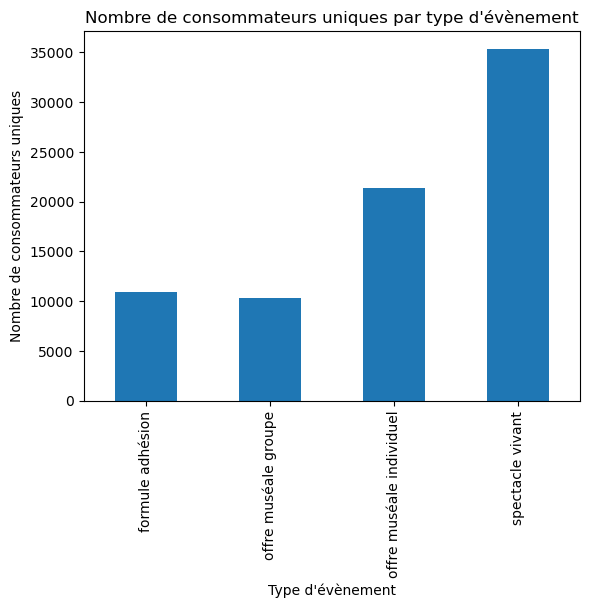

In [22]:
# Nombre de consommateurs uniques par type d'évènement

event_counts = customer.groupby('name_event_types')['customer_id'].nunique()

event_counts.plot(kind='bar')
plt.xlabel("Type d'évènement")
plt.ylabel('Nombre de consommateurs uniques')
plt.title("Nombre de consommateurs uniques par type d'évènement")
plt.show()

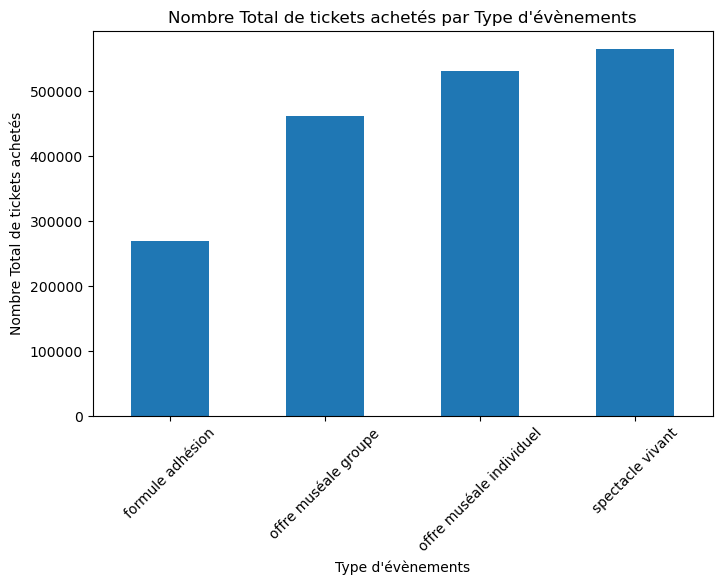

In [23]:
# Nombre Total de tickets achetés par Type d'évènements

total_tickets_by_event = customer.groupby('name_event_types')['nb_tickets'].sum()

total_tickets_by_event.plot(kind='bar', figsize=(8, 5))
plt.xlabel("Type d'évènements")
plt.ylabel('Nombre Total de tickets achetés')
plt.title("Nombre Total de tickets achetés par Type d'évènements")
plt.xticks(rotation=45)
plt.show()

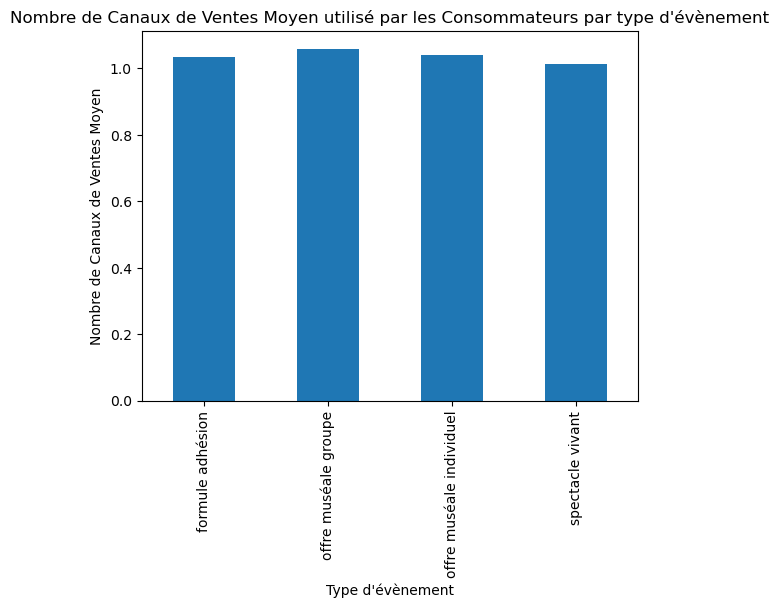

In [24]:
# Nombre de Canaux de Ventes Moyen utilisé par les Consommateurs par type d'évènement

avg_supp_event = customer.groupby('name_event_types')['nb_suppliers'].mean()
avg_supp_event.plot(kind='bar')
plt.xlabel("Type d'évènement")
plt.ylabel('Nombre de Canaux de Ventes Moyen')
plt.title("Nombre de Canaux de Ventes Moyen utilisé par les Consommateurs par type d'évènement")
plt.show()

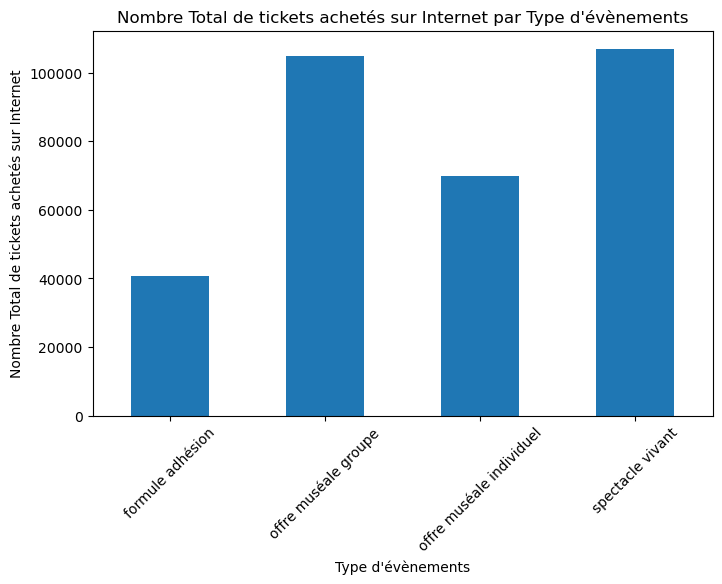

In [25]:
# Nombre Total de tickets achetés sur Internet par Type d'évènements

nb_tickets_internet = customer.groupby('name_event_types')['nb_tickets_internet'].sum()
nb_tickets_internet.plot(kind='bar', figsize=(8, 5))
plt.xlabel("Type d'évènements")
plt.ylabel('Nombre Total de tickets achetés sur Internet')
plt.title("Nombre Total de tickets achetés sur Internet par Type d'évènements")
plt.xticks(rotation=45)
plt.show()

# 3 - Caractéristiques Démographiques (peu exploitable)

In [26]:
customer.columns

Index(['customer_id', 'birthdate', 'street_id', 'is_partner', 'gender',
       'is_email_true', 'opt_in', 'structure_id', 'profession', 'language',
       'mcp_contact_id', 'last_buying_date', 'max_price', 'ticket_sum',
       'average_price', 'fidelity', 'average_purchase_delay',
       'average_price_basket', 'average_ticket_basket', 'total_price',
       'purchase_count', 'first_buying_date', 'country', 'age', 'tenant_id',
       'event_type_id', 'nb_tickets', 'nb_purchases', 'total_amount',
       'nb_suppliers', 'vente_internet_max', 'purchase_date_min',
       'purchase_date_max', 'time_between_purchase', 'nb_tickets_internet',
       'name_event_types', 'avg_amount', 'nb_campaigns', 'nb_campaigns_opened',
       'time_to_open'],
      dtype='object')

In [27]:
def percent_of_na(df, column):
    na_percentage = df[column].isna().mean() * 100
    non_na_percentage = 100 - na_percentage
    
    labels = ['Valeurs Manquantes', 'Non-Valeurs Manquantes']
    sizes = [na_percentage, non_na_percentage]
    colors = ['#ff9999','#66b3ff']
    explode = (0.1, 0)

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal') 
    plt.title('Pourcentage de Valeurs Manquantes : {}'.format(column))
    plt.show()

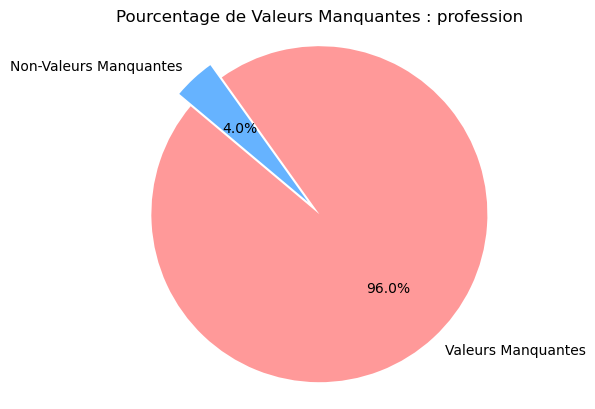

In [28]:
percent_of_na(customer, 'profession')

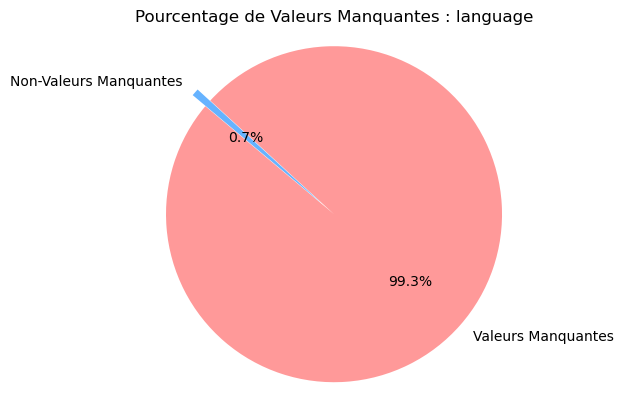

In [29]:
percent_of_na(customer, 'language')